In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import math
from xgboost import XGBRegressor

In [2]:
# Reading Esol and SMILES data

esol_data = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/esol.csv')
mol_smiles = esol_data['SMILES']
log_s = esol_data['measured log(solubility:mol/L)']
esol_data['number'] = esol_data.index
mol_number = esol_data['number']
mol_name = esol_data['Compound ID']

In [3]:
# generate fingeprints: Morgan fingerprint with radius 8 and 2048 nBits
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 8, nBits=2048) for x in esol_data['SMILES']]
#convert fps into numpy array
np_fps = np.asarray(fps)
np_fps.shape

# generate MACCS fingerprints
#maccs_fps = [MACCSkeys.GenMACCSKeys (Chem.MolFromSmiles(x)) for x in gpHSP_data['smiles']]

(1144, 1024)

Fold:1, Train set: 953, Test set:191
0.8462640254600511
1.1723682730850382
0.6877462509914365


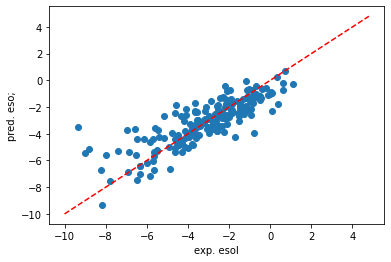

Fold:2, Train set: 953, Test set:191
0.9102240590737127
1.2506978059715312
0.6251259926230044


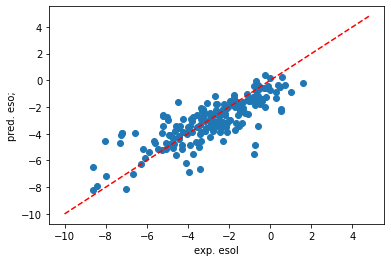

Fold:3, Train set: 953, Test set:191
0.8240525553761664
1.0808783553715506
0.7204172871180987


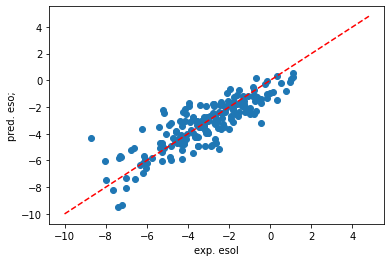

Fold:4, Train set: 953, Test set:191
0.8579564596901388
1.1809213876326095
0.7067068493350346


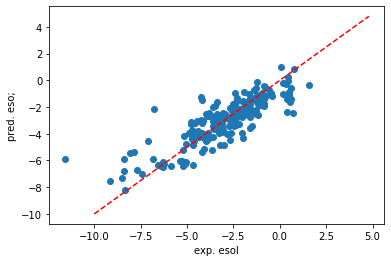

Fold:5, Train set: 954, Test set:190
0.8204164795168137
1.1144039452024814
0.7293148152341835


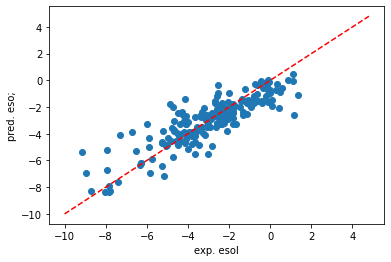

Fold:6, Train set: 954, Test set:190
0.8899009164695677
1.189642677910967
0.6601346130516176


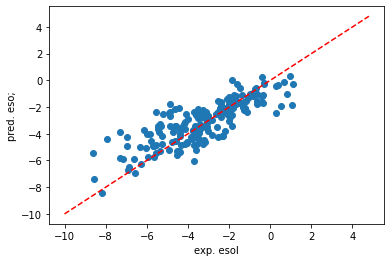

In [4]:
# split the data into 6 folds.  
# use'kf'(KFold splitting stratergy) object as input to cross_val_score() method
kf =KFold(n_splits=6, shuffle=True, random_state=42)

# initial fold number
cnt = 1

# split()  method generate indices to split data into training and test set.
for train_index, test_index in kf.split(np_fps, log_s):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
  
    fps_train, fps_test = np_fps[train_index], np_fps[test_index]
    esol_train, esol_test = log_s[train_index], log_s[test_index]
    index_train, index_test = mol_number[train_index], mol_number[test_index]
    smiles_train, smiles_test = mol_smiles[train_index], mol_smiles[test_index]
    
    # training model
    model = XGBRegressor().fit(fps_train, esol_train)
    esol_pred = model.predict(fps_test)
    
    # print out MAE, RMSE and R2
    print(mean_absolute_error (esol_test, esol_pred))
    print(math.sqrt(mean_squared_error(esol_test, esol_pred)))
    print(r2_score (esol_test, esol_pred))
    
    # convert predictions into df and concat molecules' index, SMILES, exp and predicted values 
    # and save into a csv file for each fold
    pd_esol_pred = pd.DataFrame(esol_pred, columns=["pred"])
    # uncertainty from XGBOOST 
    #pd_esol_dists = pd.DataFrame(esol_dists, columns=["dists"])
    xg_output = pd.concat((index_test.reset_index(), smiles_test.reset_index(), esol_test.reset_index(), pd_esol_pred), ignore_index=True, axis=1)
    xg_output.to_csv(f'fps_xgboost_esol_total_fold_{cnt}.csv')

    # plot exp vs predicted values
    ln = np.arange(-10, 5, 0.2)
    plt.plot(ln, ln,'r--')
    plt.scatter(esol_test, esol_pred)
    plt.plot(color='green')

    plt.xlabel('exp. esol')
    plt.ylabel('pred. eso;')
    plt.show()
    
    cnt += 1
    